# Quantum Harmonic Oscillator 

Here we compute the ground-state of the $ndim$-dimensional quantum harmonic oscillator for a system of $npart$ particles. The Hamiltonian of the system reads:

$$ H = -\frac{1}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \frac{m \omega^2}{2}\sum_{i=1}^{npart} \vec{x}_i^2 $$

For simplicity, we take $m=1$ and $\omega=1$. According to the variational principle of quantum mechanics, for any trial wave function $|\psi_T\rangle$,

$$ \frac{\langle \psi_V | H | \psi_V \rangle}{\langle \psi_V | \psi_V \rangle} ~ \ge ~ E_0 = \frac{1}{2} ndim * npart $$

In this notebook, we utilize a FFNN to solve the problem

$$ \langle x | \psi_V \rangle = \psi_V(x) = \exp [\mathcal{U}(x)]$$

Note that the ground state corresponds to

$$ \psi_0(x) = \exp \left(-\frac{1}{2}\sum_i \vec{x}_i^2\right) $$


In [54]:
# Load the libraries that we need for this notebook
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

import jax
import jaxlib
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, grad, jit, vmap, pmap, jacfwd, jacrev
from jax.example_libraries import stax
from jax.lax import fori_loop
from functools import partial

from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, Gelu, LogSoftmax, Softplus, Tanh, 
                                   Sigmoid, elementwise, FanOut, FanInConcat)
from jax.nn.initializers import glorot_normal, normal, ones, zeros

from jax.tree_util import tree_flatten
from jax.flatten_util import ravel_pytree

In [55]:
class Wavefunction(object):
    """Create a simple wave function in ndim dimensions 
       and for npart particles using a dense feed-forward neural net
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16
        
    def build(self, key):
        in_shape = (-1, self.npart, self.ndim)

        self.net_init, self.net_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(1), 
)     
        key, key_input = jax.random.split(key)
        _, net_params = self.net_init(key_input, in_shape) 
            
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]

        return net_params, num_flat_params
        
    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, inputs):
        logpsi = self.net_apply(params, inputs)
        logpsi = jnp.reshape(logpsi, ())
        logpsi = logpsi - 0.04 * jnp.sum(inputs**2)
        return logpsi
    
    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, inputs):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, inputs) 
        return vmap_logpsi
    
    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters 

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters 
    
    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

In [56]:
class Hamiltonian(object):
    """Expectation values of the kinetic and potential energies of 
       a collection of independent harmonic oscillators.
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction

    @partial(jit, static_argnums=(0,))
    def potential (self, x):
        """ The HO oscillator potential is given by 
        V = <x|V|psi> / <x|psi> = 1/2 sum_i x_i^2
        """
        pe = 0.5 * jnp.sum(x**2, axis=(1,2))
        return pe

    @partial(jit, static_argnums=(0,))
    def kinetic (self, params, x):
        """ Use autodiff to compute the kinetic energy
        """
        logpsi = lambda x: self.wavefunction.logpsi(params, x)
        d_logpsi = jax.grad(logpsi)(x)
        d2_logpsi = jax.hessian(logpsi)(x)
        d2_logpsi = jnp.reshape(d2_logpsi,(self.ndim * self.npart, self.ndim * self.npart)) 
        ke = - 0.5 * ( jnp.trace(d2_logpsi) + jnp.sum( d_logpsi * d_logpsi ) ) 
        return ke

    @partial(jit, static_argnums=(0,))
    def energy (self, params, inputs):
        """ Sum of the kinetic and the potential energy """
        ke = vmap(self.kinetic, in_axes=(None, 0))(params, inputs)
        pe = self.potential(inputs)
        en = ke + pe
        return ke, pe, en

In [57]:
class Metropolis(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    """
    def __init__(self,   
          nwalk : int, 
          npart : int,
          ndim : int,
          neq : int, 
          nav : int, 
          nvoid : int, 
          sig : float,
          sig_i : float,
          wavefunction : callable):

          self.nwalk = nwalk 
          self.npart = npart
          self.ndim = ndim
          self.neq = neq
          self.nav = nav
          self.nvoid = nvoid
          self.sig = sig
          self.sig_i = sig_i
          self.wavefunction = wavefunction

# Function that performs nvoid Metropolis steps
    @partial(jit, static_argnums=(0,))
    def step(self, params, x_o, key_o):
        
        def single_step(i, loop_carry):
            x_o, key_o, acc_o = loop_carry    
            log_wpsi_o = self.wavefunction.vmap_logpsi(params, x_o)
            key_o, key_input = jax.random.split(key_o)
            x_n = x_o + self.sig * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
            log_wpsi_n = self.wavefunction.vmap_logpsi(params, x_n)
            prob = jnp.exp( 2 * ( log_wpsi_n - log_wpsi_o ) )
            key_o, key_input = jax.random.split(key_o)
            accept = jnp.greater(prob, jax.random.uniform(key_input, shape=[self.nwalk]))
            x_o = jnp.where(accept.reshape([self.nwalk,1,1]), x_n, x_o)
            acc_o = accept.astype('float64')
            return x_o, key_o, acc_o
        
        acc_o = jnp.zeros(self.nwalk)
        x_o, key_o, acc_o = fori_loop(0, self.nvoid, single_step, (x_o, key_o, acc_o) )
        return x_o, acc_o, key_o

# Function that perform the full Metropolis walk and returns the path and the acceptance
    def walk(self, params, key):
        key_o, key_input = jax.random.split(key)
        x_o = self.sig_i * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
        for i in range (neq): 
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
        x_s = []
        acc_s = []
        for i in range (self.nav): 
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
            x_s.append(x_o)
            acc_s.append(acc_o)
        x_s = jnp.concatenate(x_s)
        acc_s = jnp.concatenate(acc_s)
        return x_s, acc_s 

In [58]:
# Define the function that computes the average and the standard deviation of each observables
@jit
def estimator(observable):
    average = jnp.mean(observable)
    average_2 = jnp.mean(observable**2)
    error = jnp.sqrt(average_2 - average**2) / jnp.sqrt(observable.shape[0]-1) 
    return average, error

In [59]:
class Optimizer(object):
    """Class that computes the energy derivative 
    f_i = 2[< E_L O_i > - 2 < E_L > < O_i >]
    and updates the parameters according to the SGD algorithm
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction
    
    @partial(jit, static_argnums=(0,))
    def getder(self, params, x):
        logpsi = lambda params: self.wavefunction.logpsi(params, x)
        dlogpsi_dp = jax.grad(logpsi)(params)
        dlogpsi_dp = self.wavefunction.flatten_params(dlogpsi_dp)
        return dlogpsi_dp

    @partial(jit, static_argnums=(0,))
    def vmap_getder(self, params, x):
        return vmap(self.getder, in_axes=(None, 0))(params, x)

# Computes the gradient of the energy f_i = 2[ < E_L O_i > - 2 < E_L > < O_i > ]
    @partial(jit, static_argnums=(0,))
    def gradient (self, params, x, en):
        nsamples = en.shape[0]
        jac = self.vmap_getder(params, x)
        jac = jac - jnp.mean(jac, axis=0)
        en = en - jnp.mean(en)
        grad_energy = 2 * jnp.matmul(en,jac) / nsamples
        return grad_energy

In [60]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes 

sig_i = 1.0         # Gaussian width for sampling the initial configuration 
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10             # Averaging steps
nvoid = 100         # Void steps between energy calculations
nwalk = 400         # Quantum Monte Carlo configurations
ndim = 2            # Spatial dimension  
npart = 1           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

key_net = random.PRNGKey(seed_net)
wavefunction = Wavefunction(ndim, npart)
params, nparams = wavefunction.build(key_net)

hamiltonian = Hamiltonian(ndim, npart, wavefunction)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, wavefunction)

In [63]:
# Define the optimization step and perform the optimization using JAX default optimizer

from jax.example_libraries import optimizers
learning_rate = 0.001
#opt_init, opt_update, get_params = optimizers.momentum(learning_rate, 0.99)
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

def step(step, key_input, opt_state):
    params = get_params(opt_state)
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s) 
    energy_average, energy_error = estimator(en)
    energy_gradient = optimizer.gradient(params, x_s, en)
    energy_gradient = wavefunction.unflatten_params( energy_gradient )    
    opt_state = opt_update(step, energy_gradient, opt_state)
    return energy_average, energy_error, opt_state

steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (401):
    key_walk, key_input = jax.random.split(key_walk)
    value, error, opt_state = step(i, key_input, opt_state)
    print("step", i, "energy = ", value, "err=", error )
    params = get_params(opt_state)
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

step 0 energy =  1.2720783057684613 err= 0.02303745604565072
step 1 energy =  1.1731618081999227 err= 0.013482905101507238
step 2 energy =  1.226406693878508 err= 0.018260213633310127
step 3 energy =  1.2135095212095675 err= 0.019087438385987254
step 4 energy =  1.2154970888157404 err= 0.028947272748275448
step 5 energy =  1.1781439429605685 err= 0.01361262351384502
step 6 energy =  1.1857941561643657 err= 0.013239941303210321
step 7 energy =  1.1466448413621275 err= 0.013013311926501648
step 8 energy =  1.176678219334416 err= 0.013868287367913724
step 9 energy =  1.1434371016137634 err= 0.01257648553310684
step 10 energy =  1.1506039448609413 err= 0.013062296384815084
step 11 energy =  1.187689984999724 err= 0.018860895279587054
step 12 energy =  1.1813517940830165 err= 0.017226585073578344
step 13 energy =  1.1090649446690442 err= 0.010270212815850326
step 14 energy =  1.2601707248102214 err= 0.025074604611354034
step 15 energy =  1.1262132003822494 err= 0.010507437458249409
step 16 

step 131 energy =  1.0152076661021623 err= 0.00446626353113964
step 132 energy =  1.019948938248757 err= 0.004608829546783583
step 133 energy =  1.0234638400269336 err= 0.005248558885029165
step 134 energy =  1.0145352159724967 err= 0.004446445570912721
step 135 energy =  1.0229653279257307 err= 0.005590998253786018
step 136 energy =  1.0230687928377449 err= 0.006423828363324591
step 137 energy =  1.013783756796472 err= 0.00387090716328153
step 138 energy =  1.0258437313080986 err= 0.004658387713739346
step 139 energy =  1.0317363772506365 err= 0.008560680262865234
step 140 energy =  1.0210838650649159 err= 0.004386552348430959
step 141 energy =  1.01834945248242 err= 0.003677135256964049
step 142 energy =  1.0164094363997984 err= 0.004449137057596177
step 143 energy =  1.02932023300867 err= 0.007533565462987755
step 144 energy =  1.0155144801751195 err= 0.003825235574787437
step 145 energy =  1.0234828429193015 err= 0.004542438759600927
step 146 energy =  1.0162526891212131 err= 0.004

step 259 energy =  1.0035853238066608 err= 0.002580307493793673
step 260 energy =  1.0029137019824068 err= 0.0021192311577988435
step 261 energy =  1.0026300102930172 err= 0.002132786250876029
step 262 energy =  1.0036573703813985 err= 0.002247413195747601
step 263 energy =  1.0053485025981472 err= 0.003207846558747651
step 264 energy =  1.0072144209974538 err= 0.0030572567717686975
step 265 energy =  1.0104593997581555 err= 0.003494530131385955
step 266 energy =  1.007473117780898 err= 0.003231236686442809
step 267 energy =  1.0063020384168688 err= 0.002324184611705809
step 268 energy =  1.0049529447772234 err= 0.002397005367181058
step 269 energy =  1.0082744224362399 err= 0.002501745721415255
step 270 energy =  1.0051848967970543 err= 0.002147857032731906
step 271 energy =  1.014085978523764 err= 0.0038021955099339843
step 272 energy =  1.004897166651516 err= 0.002665547941976138
step 273 energy =  1.013302061384385 err= 0.003791464624641071
step 274 energy =  0.9994905116569806 err

step 387 energy =  1.008787965363532 err= 0.003908154275207902
step 388 energy =  1.011413459629001 err= 0.006594720914220702
step 389 energy =  1.0019154016509826 err= 0.0017817542642057282
step 390 energy =  1.0036709354207844 err= 0.0018776717862914974
step 391 energy =  1.0027976439930972 err= 0.0018043795328068042
step 392 energy =  1.0043439457785681 err= 0.0020546814575720467
step 393 energy =  1.0023037674091932 err= 0.0028171967275798693
step 394 energy =  1.0057438809748382 err= 0.003227165482291646
step 395 energy =  1.0082688455959747 err= 0.003367277480218053
step 396 energy =  1.0055971040120273 err= 0.0019672811508936855
step 397 energy =  1.0055183908936416 err= 0.00397205214056473
step 398 energy =  1.0021563863162952 err= 0.0019007462973000546
step 399 energy =  1.0017173966525486 err= 0.002358166124211335
step 400 energy =  1.007096324325839 err= 0.0031700354399678107


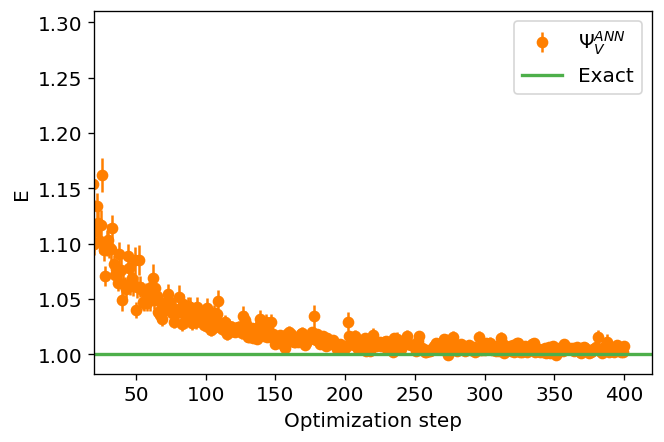

In [67]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

step = jnp.asarray(steps_history)
energy = jnp.asarray(energy_history)
error = jnp.asarray(error_history)

p1 = plt.errorbar(step, energy, yerr=error, fmt='o', errorevery=1, markevery = 1, label = r'$\Psi_{V}^{ANN}$', zorder = 0, color = palette(4))
p2 = plt.axhline(y= 0.5 * npart * ndim, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

#plt.ylim(0.46,1)
plt.xlim(20,)

plt.xlabel(r'Optimization step')
plt.ylabel('E')
plt.legend([p1, p2], [r'$\Psi_{V}^{ANN}$', r'Exact'], loc = 'upper right')
plt.savefig("ho_energies.pdf",bbox_inches = 'tight')
plt.show()

In [ ]:
# In the one-dimesional case, print the wave function
x = jnp.linspace(0,10,100)
f_exact = jnp.exp(-x**2/2)
f_exact = f_exact / jnp.sqrt(jnp.trapz(f_exact**2, x))
f_ann = []
for i in range (len(params_saved)):
    f_ann.append(jnp.exp(jnp.asarray(wavefunction.vmap_logpsi(params_saved[i], x))))
    f_ann[i] = f_ann[i] / jnp.sqrt(jnp.trapz(f_ann[i]**2, x))
    
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(x, f_ann[0], '-', label = r'$n=0$')
plt.plot(x, f_ann[100], '-', label = r'$n=100$')
plt.plot(x, f_ann[200], '-', label = r'$n=200$')
plt.plot(x, f_ann[300], '-', label = r'$n=300$')
plt.plot(x, f_ann[400], '-', label = r'$n=400$')
plt.plot(x, f_exact, '--', label = r'Exact')
plt.xlabel('x [Arbitrary Units]')
plt.ylabel(r'$\Psi(x)$')
plt.legend(loc = 'upper right')
plt.savefig("ho_wavefunction.pdf",bbox_inches = 'tight')
plt.xlim(0, 5)
plt.show()

# Deuteron with a LO, pionless-EFT potential 

Extend the above code to compute the ground-state of the deuteron, from the pionless-EFT Hamiltonian

$$ H = -\frac{\hbar^2}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \sum_{i<j}\sum_{p=1}^4v^p(r_{ij})O^p_{ij}$$

where

$$O^p_{ij} = 1, \tau_{ij}, \sigma_{ij}, \sigma_{ij}\tau_{ij}$$


You can use a neural-network Slater-Jastrow ansatz of the form 

$$ \Psi(X) = e^{\mathcal{U}(\mathbf{r_1},\mathbf{r_2})} \Phi(S) $$

In its simplest form, you can ignore the Slater determinant, and the spin-isospin degrees of freedom, since

$$ |\Phi(S)\rangle = \langle S | \frac{1}{\sqrt{2}}[|p\uparrow\rangle_1 |n\uparrow\rangle_2 - |n\uparrow\rangle_1 |p\uparrow\rangle_2$$

Under this assumption, which is exact for the deuteron, $\tau_{12} = -3$, and $\sigma_{12} = 1$. Therefore, the potential reduces to 

$$ \sum_{p=1}^4v^p(r_{ij})O^p_{ij} = v^c(r_{12}) -3 v^\tau(r_{12}) + v^\sigma(r_{12}) - 3 v^{\sigma\tau}(r_{12}) $$

In [68]:
class NuclearPotential(object):
    """Class that computes the pionless-EFT potential "o" of PRC 103, 054003(2021)
    """
    def __init__(self):
        self.hc = 197.327053      
        self.R0 = 1.54592984
        self.R1 = 1.83039397
        self.C01 = -5.27518671
        self.C10 = -7.04040080
        
    def v2b(self, rr):
        pot_2b = jnp.zeros(6)
        C0_r = 1. / (jnp.sqrt(jnp.pi)*self.R0)**3*jnp.exp( -( rr / self.R0 )**2 )
        C1_r = 1. / (jnp.sqrt(jnp.pi)*self.R1)**3*jnp.exp( -( rr / self.R1 )**2 )
        pot_2b = pot_2b.at[0].set( 3. * ( self.C01 * C1_r + self.C10 * C0_r ) )
        pot_2b = pot_2b.at[1].set( self.C01 * C1_r - 3. * self.C10 * C0_r )
        pot_2b = pot_2b.at[2].set( -3. * self.C01 * C1_r + self.C10 * C0_r )
        pot_2b = pot_2b.at[3].set( -1. * ( self.C01 * C1_r + self.C10 * C0_r ) )
        pot_2b = pot_2b / 16. * self.hc
        return pot_2b

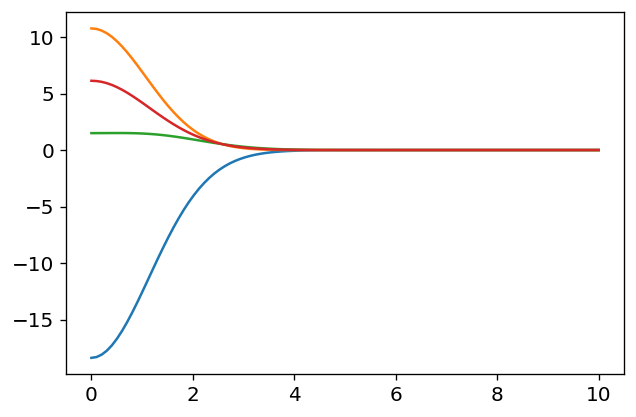

In [70]:
potential = NuclearPotential()
rr = np.linspace(0,10,100)
v_rr = np.zeros((6,100))
for i in range (100):
    v_rr[:,i] = potential.v2b(rr[i])
    
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(rr, v_rr[0,:] )
plt.plot(rr, v_rr[1,:] )
plt.plot(rr, v_rr[2,:] )
plt.plot(rr, v_rr[3,:] )